In [1]:
%matplotlib inline
import os
import math
import shutil
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import IPython.display as ipd

import librosa

In [2]:
# check permissions
# read
DATA_FOLDER = '/projects/data/data_v_7_stc'
METAFOLDER = os.path.join(DATA_FOLDER, 'meta')
METAFILE = os.path.join(METAFOLDER, 'meta.txt')
AUDIO_FOLDER = os.path.join(DATA_FOLDER, 'audio')

# write
REFINED_FOLDER = os.path.join(DATA_FOLDER, 'refined', '')
REFINED_META = os.path.join(METAFOLDER, 'refined_meta.txt')

In [29]:
df = pd.read_csv(METAFILE, sep='\t', header=None)
df.columns = ['file', 'unk1', 'unk2', 'duration', 'type']

In [30]:
df.sample(5)

,file,unk1,unk2,duration,type
1840,bg_0136_time_stretch_1.wav,office,0,2.504308,bags
6696,tt_k_0009_time_stretch_2.wav,office,0,9.711519,keyboard
221,background_0015_time_stretch_6.wav,office,0,6.384444,background
3694,d_0023_time_stretch_1.wav,office,0,1.147120,door
1687,bg_0098_time_stretch_0.wav,office,0,1.792925,bags


In [31]:
uniqs = df['type'].unique()

# Find file count of each type

In [32]:
rows_count = lambda df, t: len(df.loc[df['type'] == t].index)
type_freqs = {name: rows_count(df, name) for name in uniqs}

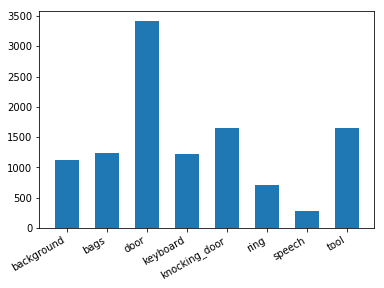

In [33]:
plt.bar(range(len(type_freqs)), list(type_freqs.values()), align='center', width=0.6)
plt.xticks(range(len(type_freqs)), list(type_freqs.keys()))
plt.setp(plt.gca().get_xticklabels(), rotation=30, horizontalalignment='right') 
 
plt.show()

# Find average durations

In [34]:
avg_duration = lambda df, t: df.loc[df['type'] == t]['duration'].mean()
type_avg_durations = {name: avg_duration(df, name) for name in uniqs}

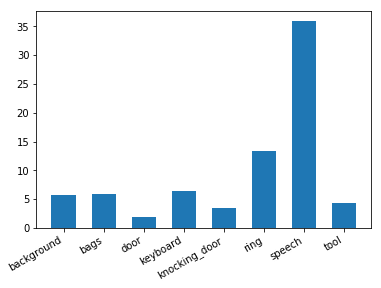

In [35]:
plt.bar(range(len(type_avg_durations)), list(type_avg_durations.values()), align='center', width=0.6)
plt.xticks(range(len(type_avg_durations)), list(type_avg_durations.keys()))
plt.setp(plt.gca().get_xticklabels(), rotation=30, horizontalalignment='right')

plt.show()

# Find total durations

In [36]:
total_duration = lambda df, t: df.loc[df['type'] == t]['duration'].sum()
type_durations = {name: total_duration(df, name) for name in uniqs}

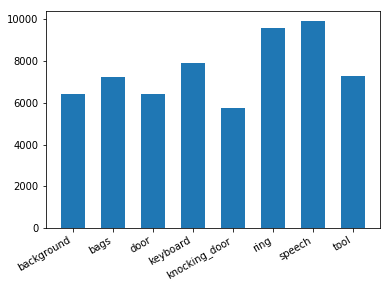

In [37]:
plt.bar(range(len(type_durations)), list(type_durations.values()), align='center', width=0.6)
plt.xticks(range(len(type_durations)), list(type_durations.keys()))
plt.setp(plt.gca().get_xticklabels(), rotation=30, horizontalalignment='right')

plt.show()

# Analyze sounds

### Histogram of file durations

Text(0.05, 0.5, 'file count')

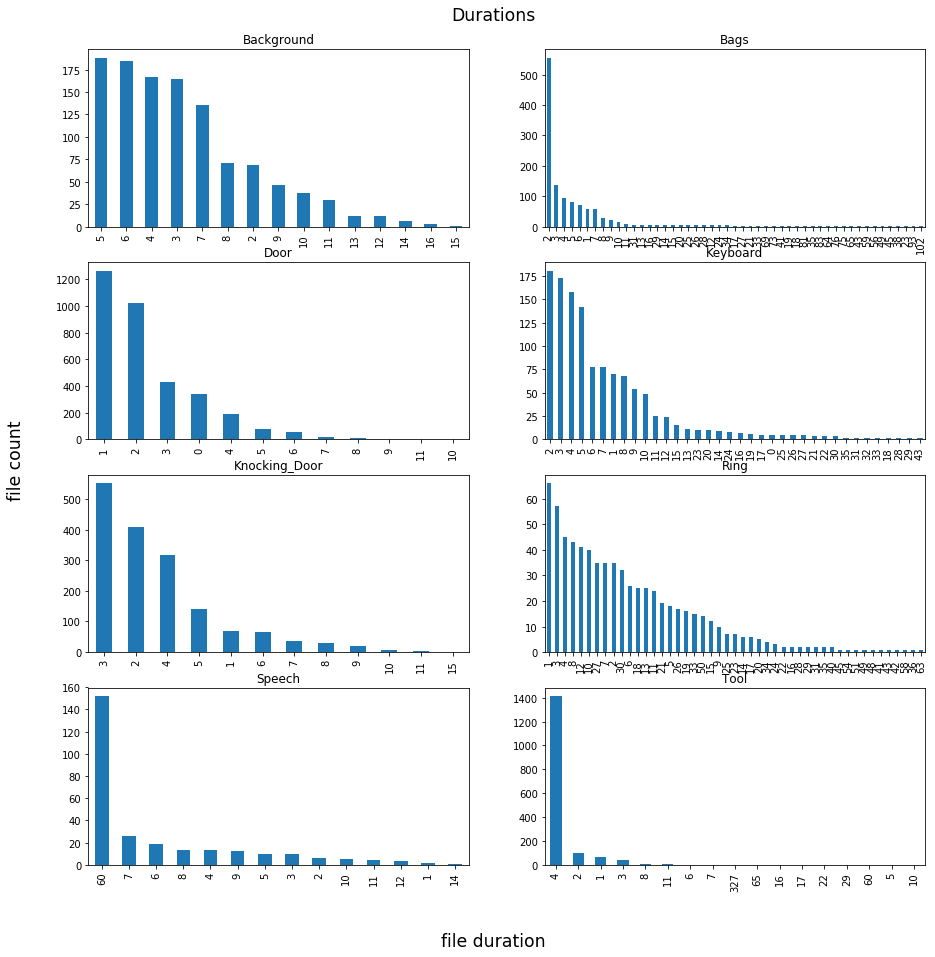

In [38]:
temp_df = pd.DataFrame()
temp_df['duration'] = df['duration'].map(lambda x: round(x))
temp_df['type'] = df['type']

fig, ax_rows = plt.subplots(nrows=4, ncols=2, figsize=(15,15))

axes = [ax for row in ax_rows for ax in row]
types = temp_df['type'].unique()

for typ, ax in zip(types, axes):
    ax.set_title(typ.title(), fontsize='large')
    temp_df.loc[temp_df['type'] == typ]['duration'].value_counts().plot(kind='bar', ax=ax)

# set title and axis labels
plt.suptitle('Durations', y=0.92, ha='center', fontsize='xx-large')
fig.text(0.5, 0.05, 'file duration', ha='center', fontsize='xx-large')
fig.text(0.05, 0.5, 'file count', va='center', rotation='vertical', fontsize='xx-large')

# Process data

## Show bitrates

In [39]:
from collections import Counter

In [40]:
c = Counter()

In [41]:
for index, row in df.iterrows():
    sample_path = row['file']
    filepath = os.path.join(AUDIO_FOLDER, sample_path)
    y, sr = librosa.load(filepath)
    c[sr] += 1

In [42]:
c

Counter({22050: 11307})

**=)**

## Bring files to target lentgh

In [9]:
TARGET_DURATION = 4  # 4s
TARGET_BITRATE = 22050

In [44]:
TARGET_ARRAY_LENGTH = TARGET_DURATION * TARGET_BITRATE
TARGET_ARRAY_LENGTH

88200

In [45]:
# clear/create folder
if os.path.exists(REFINED_FOLDER):
    shutil.rmtree(REFINED_FOLDER)
os.makedirs(REFINED_FOLDER)    

In [46]:
refined_df = pd.DataFrame(columns=df.columns)

for _, row in df.iterrows():
    sample_path = row['file']
    filepath = os.path.join(AUDIO_FOLDER, sample_path)
    y, sr = librosa.load(filepath)
    
    # Trim leading and trailing silence
    trimmed_y, _ = librosa.effects.trim(y)
    # difference coefficient between real and desired lengths
    k = TARGET_ARRAY_LENGTH/len(trimmed_y)
    
    if k > 1:
        # file is shorter that TARGET_DURATION
        # so repeat y array to desired length
        repeated_y = trimmed_y.repeat(math.ceil(k))[:TARGET_ARRAY_LENGTH]
        new_ys = [repeated_y, ]
    elif k < 1:
        # file is longer that TARGET_DURATION
        # split y to arrays of desired length
        break_indcies = [i*TARGET_ARRAY_LENGTH for i in range(1, math.ceil(1/k))]
        arrays = np.array_split(trimmed_y, break_indcies)
        # exclude trailing incomplete array
        new_ys = arrays[:-1]
    else:
        # file has perfect length
        new_ys = [trimmed_y, ]
            
    for i, new_y in enumerate(new_ys):
        # write arrays to file and fill dataframe
        name, ext = os.path.splitext(row['file'])
        new_name = '{name}__{i}{ext}'.format(name=name, i=i, ext=ext)
        path = os.path.join(REFINED_FOLDER, new_name)
        
        librosa.output.write_wav(path, new_y, sr)
        
        refined_row = {
            'file': new_name,
            'unk1': row['unk1'],
            'unk2': row['unk2'],
            'duration': len(new_y)/TARGET_BITRATE,
            'type': row['type']
        }
        
        refined_df = pd.concat([refined_df,
                                pd.DataFrame([refined_row.values()], columns=df.columns)],
                               ignore_index=True)                

In [47]:
refined_df.sample(10)

,file,unk1,unk2,duration,type
11703,ring_0445__1.wav,office,0,4.0,ring
2880,bg_0162_time_stretch_3__0.wav,office,0,4.0,bags
3835,door_0037_time_stretch_8__0.wav,office,0,4.0,door
5081,d_0053_time_stretch_8__0.wav,office,0,4.0,door
6732,t_door_0090_time_stretch_11__0.wav,office,0,4.0,door
13349,speech_0015_slice_4__13.wav,office,0,4.0,speech
2483,bg_0063_time_stretch_1__0.wav,office,0,4.0,bags
14628,speech_0038_slice_2__8.wav,office,0,4.0,speech
7465,k_0020_time_stretch_1__0.wav,office,0,4.0,keyboard
15031,tool_0233__0.wav,office,0,4.0,tool


### Save dataframe

In [48]:
refined_df.to_csv(REFINED_META, sep='\t', index=False)

# Create smth for ml

### -1) additional imports

### 0) load dataframe

In [3]:
refined_df = pd.read_csv(REFINED_META, sep='\t')

### 1) shuffle dataframe and create categorical column for type

In [4]:
refined_df = refined_df.sample(frac=1).reset_index(drop=True)

In [5]:
refined_df.type = pd.Categorical(refined_df.type)
refined_df['code'] = refined_df.type.cat.codes

### 2) create train data generator

In [64]:
def train_generator():
    for row in refined_df.iterrows():
        data = row[1]
        file = os.path.join(REFINED_FOLDER, data['file'])
        print(file)
        y, sr = librosa.load(file)
        
        stfts = tf.contrib.signal.stft(y,
                                       frame_length=1024,
                                       frame_step=512,
                                       fft_length=1024)
        
        magnitude_spectrograms = tf.abs(stfts)

        log_offset = 1e-6
        log_magnitude_spectrograms = tf.log(magnitude_spectrograms + log_offset)

        num_spectrogram_bins = magnitude_spectrograms.shape[-1].value
        lower_edge_hertz = 80.0
        upper_edge_hertz = 7600.0
        num_mel_bins = 64
        
        linear_to_mel_weight_matrix = tf.contrib.signal.linear_to_mel_weight_matrix(
            num_mel_bins,
            num_spectrogram_bins,
            sr,
            lower_edge_hertz,
            upper_edge_hertz)
        
        mel_spectrograms = tf.tensordot(magnitude_spectrograms, linear_to_mel_weight_matrix, 1)

        mel_spectrograms.set_shape(magnitude_spectrograms.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:])
        )

        log_mel_spectrograms = tf.log(mel_spectrograms + log_offset)
        
        num_mfccs = 16
        mfccs = tf.contrib.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_mfccs]
        
#         win_length = math.ceil( len(y)/(sr/1000)/ 25 ) # 25ms
#         hop_length = math.ceil( len(y)/(sr/1000)/ 15 ) # 15ms

        mfccs = tf.reshape(
            mfccs,
            (*mfccs.shape, 1),
            name=None
        )

        yield mfccs, data['code']

### 3) Create, compile, train model (не работает)

In [65]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D

# конфиг:
# - 2 слоя Conv2D
# - слой Flatten
# - 2 слоя Dense
# - активационная функция softmax

input_shape = (16, 10, 1)

model = Sequential([
    Conv2D(16, kernel_size=(2, 2), input_shape=input_shape),
    Conv2D(32, kernel_size=(3, 3)),
    Flatten(),
    Dense(16),
    Dense(16),
    Activation('softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer='adam')

model.fit_generator(train_generator(), steps_per_epoch=10, epochs=10, verbose=1)

Epoch 1/10
/projects/data/data_v_7_stc/refined/ring_0539__3.wav
/projects/data/data_v_7_stc/refined/d_0082_time_stretch_13__0.wav


TypeError: object of type 'Tensor' has no len()

In [66]:
tg = train_generator()

In [67]:
item = next(tg)
item[0]

/projects/data/data_v_7_stc/refined/ring_0539__3.wav


<tf.Tensor 'Reshape_3:0' shape=(171, 16, 1) dtype=float32>

In [40]:
(*(item[0].shape), 1)

(Dimension(171), Dimension(16), 1)